**Autor**: &nbsp; Pedro Martín Calzada &nbsp; (pedro.martinc@estudiante.uam.es)

# Curva de potencia con GPs (MAE)

El objetivo de este notebook es modelar la curva de potencia de un aerogenerador. La estrategia consiste en entrenar un proceso gaussiano para cada kernel utilizando los datos del año 2020 como conjunto de entrenamiento, y evaluar su desempeño en validación con los datos de 2021. Se escogerá aquel kernel que presente el menor error absoluto medio (MAE).

## Datos Kerlmarsh Nº6 (2020-2021)

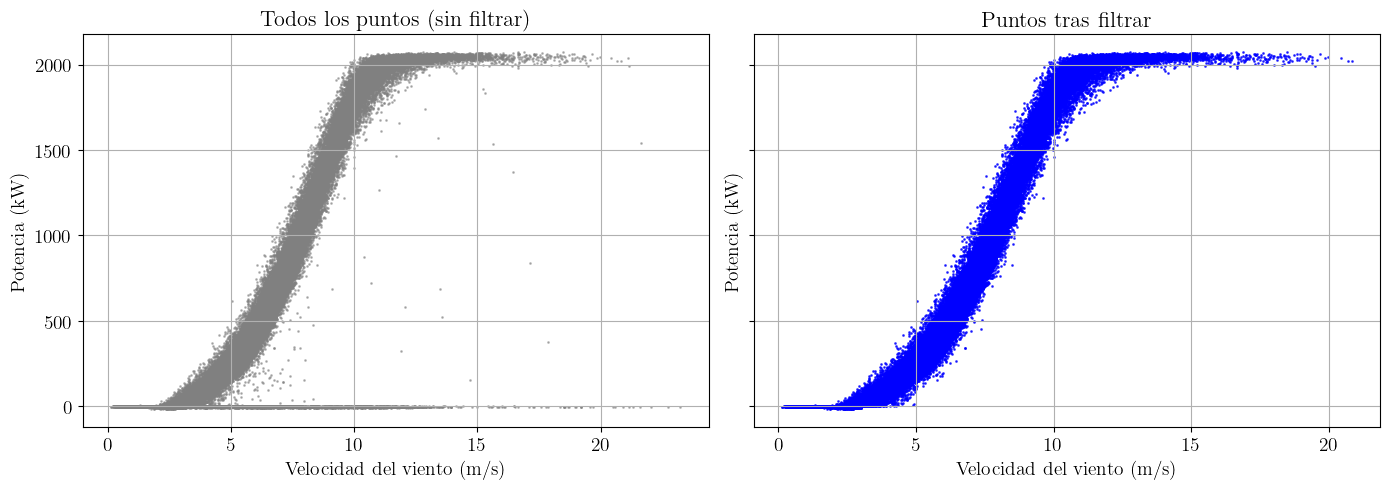

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Gráficas con texto en Latex.
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'

# Se importan los datos de 2020 y 2021 de sus respectivos CSV y se unen/concatenan para formar un df único.
df_2020 = pd.read_csv("data_2020.csv")
df_2021 = pd.read_csv("data_2021.csv")
df = pd.concat([df_2020, df_2021], ignore_index=True)

# Velocidad del viento y potencia activa.
V = df['Wind speed (m/s)']
P = df['Power (kW)']

# Máscara para limpieza o filtrado de datos.
# Muchas de las condiciones están basadas en la eliminación de puntos en rectángulos que se intersecan por lo que son redundantes (hay intersecciones).
# Se ajustan a partir de la visualización de las gráficas.
mask = (
    (P > 0) | (V < 3)          # Eliminación de potencias positivas por encima de la velocidad de arranque.
) & (V <= 21) & ~(             # Se descartan velocidades mayores de 21 m/s.
    ((V > 15) & (P < 1900)) |  # Otras condiciones de filtrado por rectángulos.
    ((V > 12) & (P < 1750)) |
    ((V > 11) & (P < 1700)) |
    ((V > 10) & (P < 1500)) |
    ((V > 7.5) & (P < 700)) |
    ((V > 7) & (P < 400)) |
    ((V > 6) & (P < 250)) |
    ((V > 5.5) & (P < 150)) |
    ((V > 5) & (P < 100))
)

# Se aplica la máscara.
V_filtered = V[mask]
P_filtered = P[mask]

# Gráficas.
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

# Datos sin filtrar.
axes[0].scatter(V, P, color='gray', s=1, alpha=0.5)
axes[0].set_title("Todos los puntos (sin filtrar)", fontsize=16)
axes[0].set_xlabel("Velocidad del viento (m/s)", fontsize=14)
axes[0].set_ylabel("Potencia (kW)", fontsize=14)
axes[0].tick_params(axis='both', labelsize=14)
axes[0].grid(True)

# Datos filtrados.
axes[1].scatter(V_filtered, P_filtered, color='blue', s=1, alpha=0.7)
axes[1].set_title("Puntos tras filtrar", fontsize=16)
axes[1].set_xlabel("Velocidad del viento (m/s)", fontsize=14)
axes[1].set_ylabel("Potencia (kW)", fontsize=14)
axes[1].tick_params(axis='both', labelsize=14)
axes[1].grid(True)

plt.tight_layout()
plt.show()

## Modelado de la curva de potencia con GPs

In [ ]:
import GPy
from sklearn.metrics import mean_absolute_error, r2_score

def run_gp_model_mae(kernel, rated_power=2050.0):
    """
    Entrena y evalúa un modelo de regresión basado en procesos gaussianos dispersos
    (Sparse GP) para modelar la curva de potencia de un aerogenerador.

    El modelo se entrena con datos de 2020 y se evalúa sobre datos de 2021, 
    ambos filtrados mediante una serie de condiciones empíricas que eliminan 
    valores anómalos o físicamente inconsistentes y outliers.

    Parámetros:
    ----------
    kernel : GPy.kern
        Kernel de GPy ya configurado para el modelo GP.
    rated_power : float, opcional (por defecto = 2050.0, para este dataset)
        Potencia nominal del aerogenerador, usada para normalizar la salida.

    Funcionalidad:
    -------------
    - Normaliza la potencia de salida.
    - Divide los datos en bins para seleccionar puntos de inducción.
    - Entrena un modelo Sparse GP con múltiples reinicios de optimización.
    - Visualiza la curva de potencia estimada y la banda de predicción del 95%.
    - Evalúa el modelo sobre datos de 2021 calculando:
        * Error absoluto medio (MAE).
        * Coeficiente de determinación (R²).
        * Porcentaje de puntos dentro del intervalo de predicción del 95% (PICP).
    - Imprime los hiperparámetros del kernel ajustado.
    """
    
    # Datos de 2020 (se toman solo velocidad del viento y potencia). Se eliminan resgitros a los que les falte alguna variable (missing values).
    df_2020 = pd.read_csv("data_2020.csv")[['Wind speed (m/s)', 'Power (kW)']].dropna()
    V_2020 = df_2020['Wind speed (m/s)']
    P_2020 = df_2020['Power (kW)']
    
    # Máscara para limpieza o filtrado de datos (misma que antes).
    mask_2020 = (
        (P_2020 > 0) | (V_2020 < 3)
    ) & (V_2020 <= 21) & ~(
        ((V_2020 > 15) & (P_2020 < 1900)) |
        ((V_2020 > 12) & (P_2020 < 1750)) |
        ((V_2020 > 11) & (P_2020 < 1700)) |
        ((V_2020 > 10) & (P_2020 < 1500)) |
        ((V_2020 > 7.5) & (P_2020 < 700)) |
        ((V_2020 > 7) & (P_2020 < 400)) |
        ((V_2020 > 6) & (P_2020 < 250)) |
        ((V_2020 > 5.5) & (P_2020 < 150)) |
        ((V_2020 > 5) & (P_2020 < 100))
    )

    # Se aplica la máscara.
    V_train = V_2020[mask_2020]
    P_train = P_2020[mask_2020]

    # Formato de entradas y normalización de la potencia.
    X = V_train.values.reshape(-1, 1)
    Y = P_train.values.reshape(-1, 1)
    Y_norm = Y / rated_power

    # Separación por bins de 0'5 m/s. 
    bin_edges = np.arange(0, X.max() + 0.5, 0.5)
    inducing_points = []
    np.random.seed(37)  # Reproducibilidad.

    # Selección de puntos de inducción distribuidos por intervalos (bins) de 0.5 m/s.
    for i in range(len(bin_edges) - 1):
        # Se seleccionan los puntos cuya velocidad está dentro del bin actual.
        bin_mask = (X[:, 0] >= bin_edges[i]) & (X[:, 0] < bin_edges[i + 1])
        bin_points = X[bin_mask]
        bin_targets = Y_norm[bin_mask]

        # Si hay puntos en el bin, se seleccionan hasta 10 aleatoriamente.
        if len(bin_points) > 0:
            idx = np.random.choice(len(bin_points), size=min(10, len(bin_points)), replace=False)
            # Se combinan velocidad y potencia normalizada en una matriz.
            inducing = np.hstack((bin_points[idx], bin_targets[idx]))
            inducing_points.append(inducing)

    # Se concatenan todos los puntos de inducción de todos los bins.
    Z = np.vstack(inducing_points)

    # Se separan las entradas (velocidades) y salidas (potencias normalizadas).
    X_inducing = Z[:, 0:1]
    Y_inducing = Z[:, 1:2]

    # Z_inducing se usa como posiciones iniciales de los inducing points en el modelo GP.
    Z_inducing = X_inducing.copy()

    # Entrenamiento del modelo (cinco iteraciones).
    model = GPy.models.SparseGPRegression(X, Y_norm, kernel=kernel.copy(), Z=Z_inducing)
    # model.optimize()
    model.optimize_restarts(num_restarts=5)

    # Visualización de resultados.
    # 500 puntos equiespaciados para ver la función modelada.
    x_pred = np.linspace(0, X.max(), 500).reshape(-1, 1)
    y_pred_norm, y_var_norm = model.predict(x_pred)
    # Se recupera la escala original.
    y_pred = y_pred_norm * rated_power
    y_std = rated_power * np.sqrt(y_var_norm)

    plt.figure(figsize=(10, 5))
    plt.scatter(V_2020, P_2020, color='#a7dbfb', s=2, alpha=0.4, label=r'\large Datos')
    plt.plot(x_pred, y_pred, color='red', lw=2, label=r'\large Curva de potencia')
    plt.fill_between(x_pred[:, 0],
                     (y_pred - 1.96 * y_std)[:, 0],
                     (y_pred + 1.96 * y_std)[:, 0],
                     color='#dd6263', alpha=0.3, label=r'\large Banda de predicción (95\%)')
    plt.scatter(X_inducing, Y_inducing * rated_power, color='#003366', s=2, alpha=0.9, label=r'\large Puntos de inducción')
    plt.title(r"Curva de potencia de Kelmarsh Nº6", fontsize=22)
    plt.xlabel(r"Velocidad del viento (m/s)", fontsize=20)
    plt.ylabel(r"Potencia (kW)", fontsize=20)
    plt.tick_params(axis='both', labelsize=18)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    print(f"Log-verosimilitud maximizada: {model.log_likelihood().item():.6f}\n")

    # Datos de 2021 (para evaluación). Mismo procedimiento que para 2020.
    df_2021 = pd.read_csv("data_2021.csv")[['Wind speed (m/s)', 'Power (kW)']].dropna()
    V_2021 = df_2021['Wind speed (m/s)']
    P_2021 = df_2021['Power (kW)']

    # Misma máscara.
    mask_2021 = (
        (P_2021 > 0) | (V_2021 < 3)
    ) & (V_2021 <= 21) & ~(
        ((V_2021 > 15) & (P_2021 < 1900)) |
        ((V_2021 > 12) & (P_2021 < 1750)) |
        ((V_2021 > 11) & (P_2021 < 1700)) |
        ((V_2021 > 10) & (P_2021 < 1500)) |
        ((V_2021 > 7.5) & (P_2021 < 700)) |
        ((V_2021 > 7) & (P_2021 < 400)) |
        ((V_2021 > 6) & (P_2021 < 250)) |
        ((V_2021 > 5.5) & (P_2021 < 150)) |
        ((V_2021 > 5) & (P_2021 < 100))
    )

    V_test = V_2021[mask_2021].values.reshape(-1, 1)
    P_test = P_2021[mask_2021].values.reshape(-1, 1)

    y_pred_norm_2021, y_var_norm_2021 = model.predict(V_test)
    # Se recupera la escala original.
    y_pred_2021 = y_pred_norm_2021 * rated_power
    y_std_2021 = rated_power * np.sqrt(y_var_norm_2021)

    # Métricas de evaluación.
    # MAE.
    mae = mean_absolute_error(P_test, y_pred_2021)
    print(f"MAE sobre datos filtrados de 2021: {mae:.6f} kW")

    # R² (coeficiente de determinación).
    r2 = r2_score(P_test, y_pred_2021)
    print(f"R² sobre datos filtrados de 2021: {r2:.6f}")

    # Porcentaje de puntos dentro del intervalo de predicción del 95% (PICP).
    lower_2021 = y_pred_2021 - 1.96 * y_std_2021
    upper_2021 = y_pred_2021 + 1.96 * y_std_2021
    within_pi_2021 = np.logical_and(P_test >= lower_2021, P_test <= upper_2021)
    picp_2021 = 100 * np.mean(within_pi_2021)
    print(f"Porcentaje de puntos dentro del IP 95% (PICP) (2021): {picp_2021:.6f}%")

    # Hiperparámetros.
    print("\nHiperparámetros del kernel:")
    for name, val in zip(model.kern.parameter_names(), model.kern.param_array):
        print(f"{name}: {val:.6f}")

### RBF

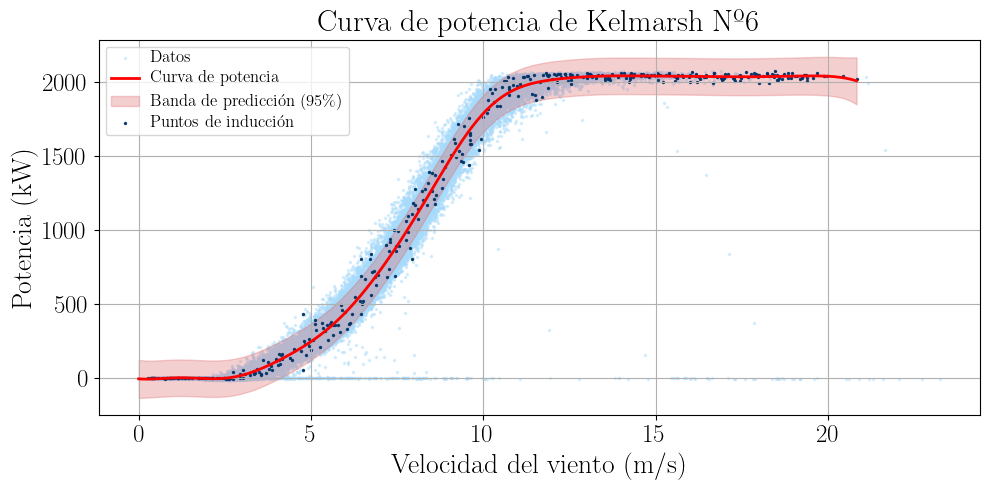

Log-verosimilitud maximizada: 106493.539598

MAE sobre datos filtrados de 2021: 35.388134 kW
R² sobre datos filtrados de 2021: 0.990400
Porcentaje de puntos dentro del IP 95% (PICP) (2021): 95.289362%

Hiperparámetros del kernel:
variance: 0.243133
lengthscale: 2.320158


In [3]:
# Se fija una función kernel. El parámetro que recibe es la dimensión del espacio de entrada (solo velocidad del viento, luego 1 dimensión).
# No es necesario fijar los hiperparámetros porque se seleccionan aleatoriamente en cada una de las cinco iteraciones
# y después se optimizan con un algoritmo (L-BFGS-B, una versión más sofisticada del desceno por el gradiente clásico).
# Se hace lo mismo con cada uno de los 5 kernels restantes.

kernel_rbf = GPy.kern.RBF(1)
run_gp_model_mae(kernel_rbf)

### Racional cuadrático

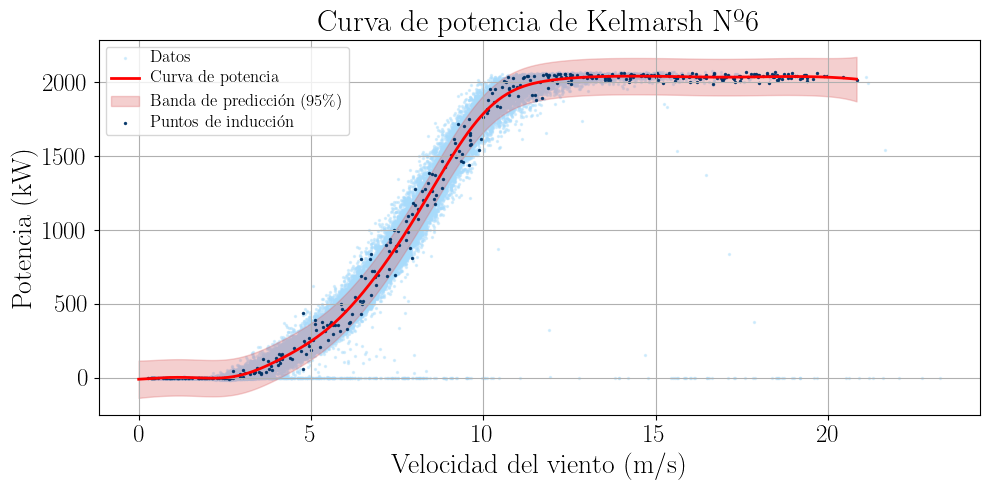

Log-verosimilitud maximizada: 106508.716605

MAE sobre datos filtrados de 2021: 35.370606 kW
R² sobre datos filtrados de 2021: 0.990400
Porcentaje de puntos dentro del IP 95% (PICP) (2021): 95.289362%

Hiperparámetros del kernel:
variance: 0.600527
lengthscale: 3.353353
power: 0.084137


In [4]:
kernel_rq = GPy.kern.RatQuad(1)
run_gp_model_mae(kernel_rq)

### Matérn 3/2

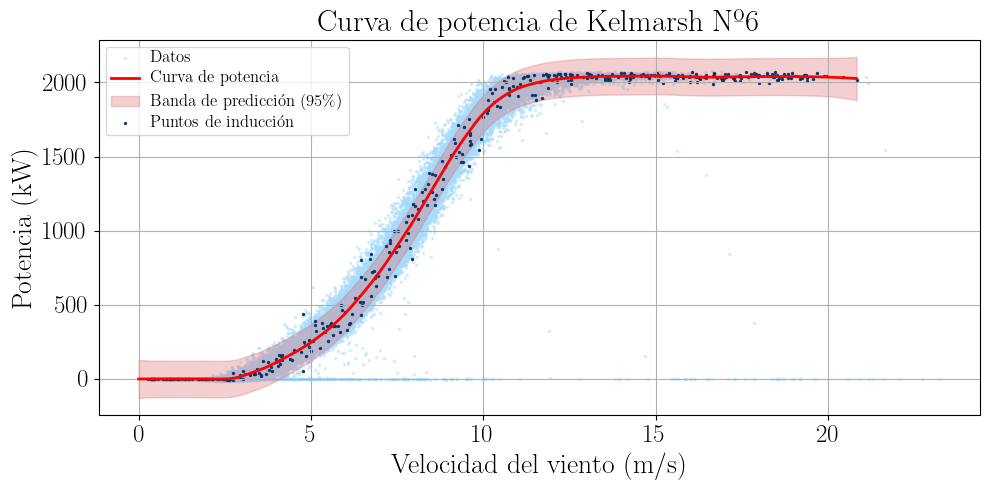

Log-verosimilitud maximizada: 106496.495813

MAE sobre datos filtrados de 2021: 35.196355 kW
R² sobre datos filtrados de 2021: 0.990403
Porcentaje de puntos dentro del IP 95% (PICP) (2021): 95.278889%

Hiperparámetros del kernel:
variance: 0.483189
lengthscale: 24.751165


In [5]:
kernel_m32 = GPy.kern.Matern32(1)
run_gp_model_mae(kernel_m32)

### Matérn 5/2

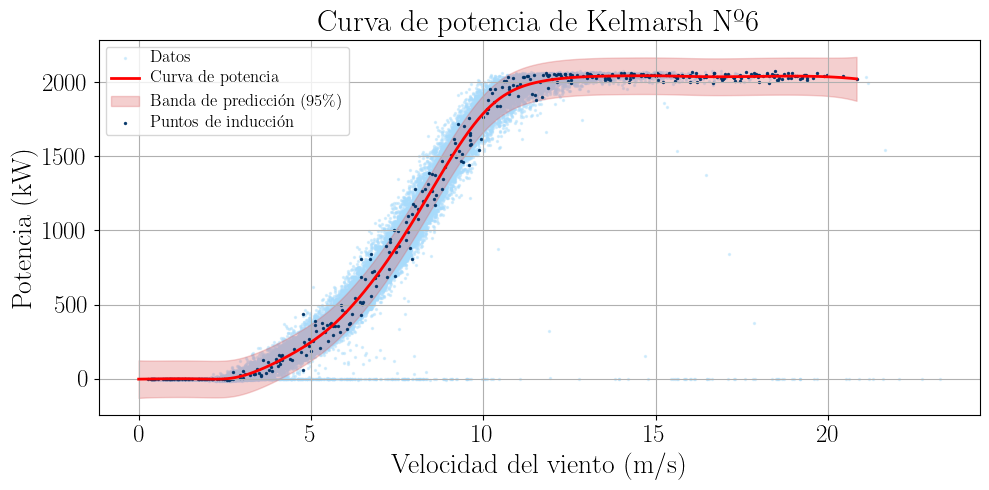

Log-verosimilitud maximizada: 106509.280855

MAE sobre datos filtrados de 2021: 35.263396 kW
R² sobre datos filtrados de 2021: 0.990402
Porcentaje de puntos dentro del IP 95% (PICP) (2021): 95.295645%

Hiperparámetros del kernel:
variance: 0.435892
lengthscale: 10.754449


In [6]:
kernel_m52 = GPy.kern.Matern52(1)
run_gp_model_mae(kernel_m52)

### RBF + Matérn 3/2

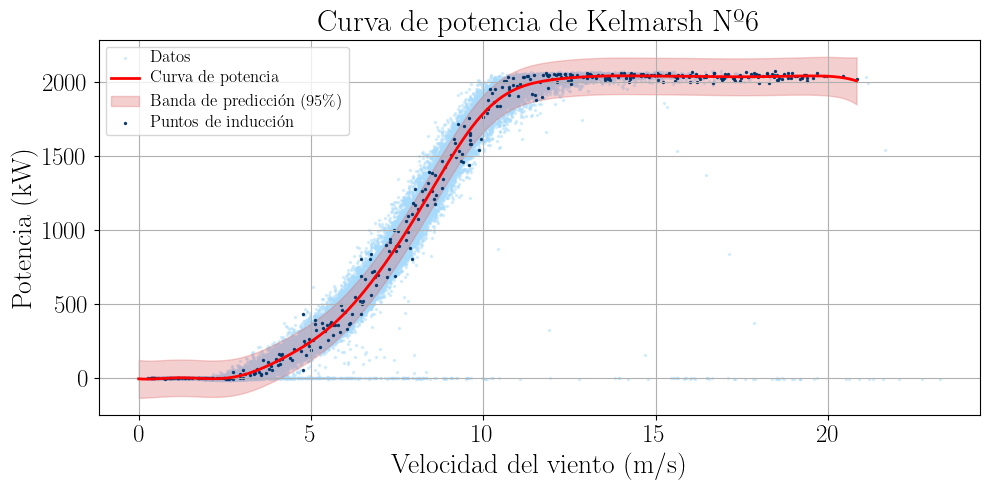

Log-verosimilitud maximizada: 106493.538545

MAE sobre datos filtrados de 2021: 35.387989 kW
R² sobre datos filtrados de 2021: 0.990400
Porcentaje de puntos dentro del IP 95% (PICP) (2021): 95.289362%

Hiperparámetros del kernel:
Mat32.variance: 0.000001
Mat32.lengthscale: 34.607351
rbf.variance: 0.243788
rbf.lengthscale: 2.320139


In [7]:
kernel_rbf_m32 = GPy.kern.Matern32(1) + GPy.kern.RBF(1)
run_gp_model_mae(kernel_rbf_m32)

### Lineal + Racional cuadrático

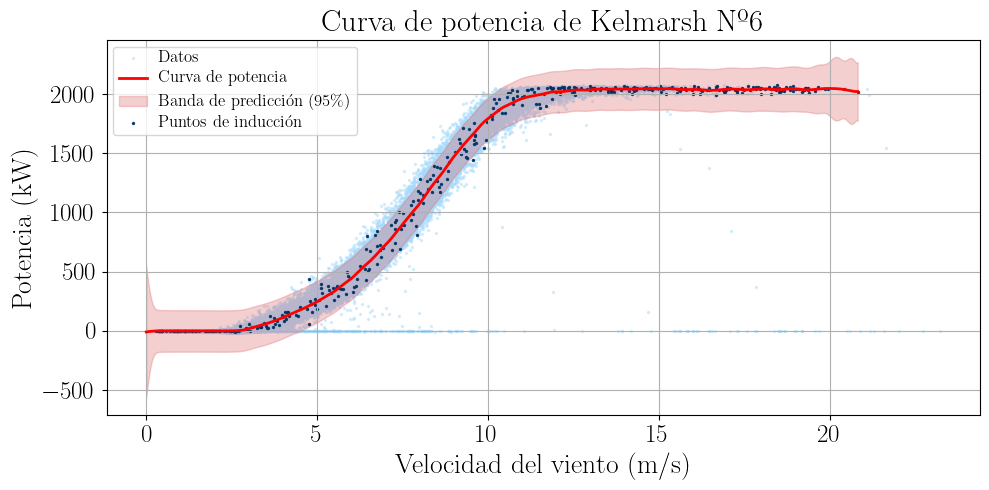

Log-verosimilitud maximizada: 101229.498480

MAE sobre datos filtrados de 2021: 35.198919 kW
R² sobre datos filtrados de 2021: 0.990399
Porcentaje de puntos dentro del IP 95% (PICP) (2021): 98.657395%

Hiperparámetros del kernel:
linear.variances: 0.999917
RatQuad.variance: 0.996381
RatQuad.lengthscale: 1.013145
RatQuad.power: 1.995251


In [4]:
kernel_linear_rq = GPy.kern.Linear(1) + GPy.kern.RatQuad(1)
run_gp_model_mae(kernel_linear_rq)

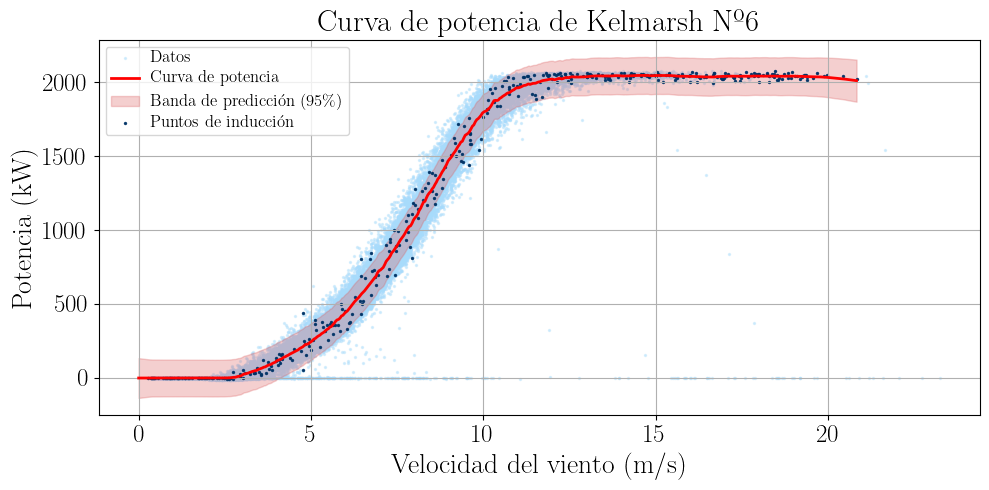

Log-verosimilitud maximizada: 106167.920666

MAE sobre datos filtrados de 2021: 35.225571 kW
R² sobre datos filtrados de 2021: 0.990387
Porcentaje de puntos dentro del IP 95% (PICP) (2021): 95.358482%

Hiperparámetros del kernel:
variance: 0.012819
lengthscale: 55.809599


In [5]:
kernel_m12 = GPy.kern.Exponential(1)
run_gp_model_mae(kernel_m12)

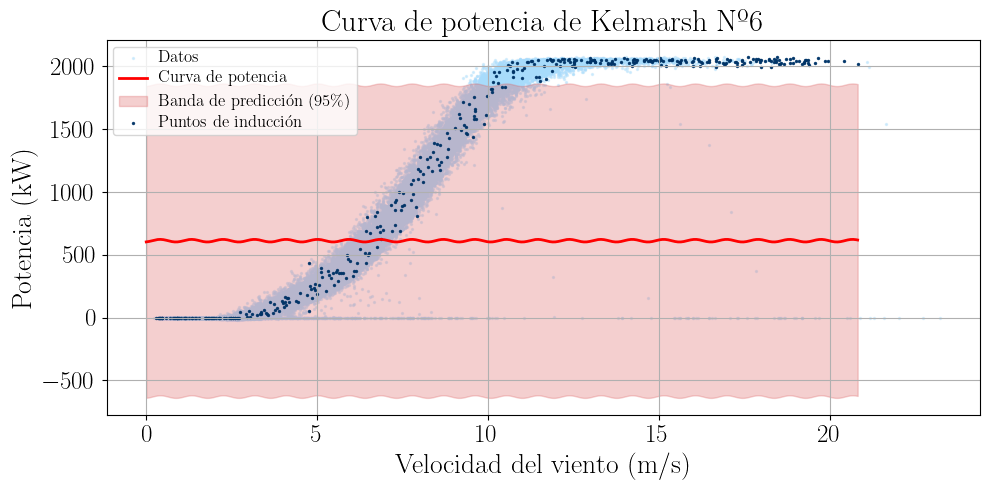

Log-verosimilitud maximizada: -12593.988867

MAE sobre datos filtrados de 2021: 489.768405 kW
R² sobre datos filtrados de 2021: -0.085047
Porcentaje de puntos dentro del IP 95% (PICP) (2021): 94.818089%

Hiperparámetros del kernel:
variance: 0.089255
period: 0.921243
lengthscale: 37.664007


In [6]:
kernel_per = GPy.kern.StdPeriodic(1)
run_gp_model_mae(kernel_per)